# Introduction

The scope of this analysis is to explore Markov Decision Processes (MDP), where training information is available only in the form of real-valued reward given for taking some actions from some states. In many ways, this type of learning (_Reinforcement Learning_) fills the gap between _Supervised Learning_, where an agent is given correct answers to learn from, and _Unsupervised Learning_ where no feedback is available at all. 

Two MDPs selected for exploration, Forest Management and Click Through Rate (CTR) optimization, are defined to contrast each other: many states and few actions versus single state and many actions. Initially, both processes are solved by Value and Policy Iteration where rewards and transitions are known (model-based). Subsequently, Q evaluation function is learned when no knowledge of the world model is assumed (model-free). 

# Value and Policy Iteration

## Forest Management

 In "Application of stochastic dynamic programming to optimal fire management of a spatially structured threatened species", Possingham provided a theoretical framework for threated species fire management. Problem can be modeled by Markov Decision Process and it is simple enough to be able to understand the optimal policy learning process.


__Fire Management Model__

   - __States__: the age of the threatened species (youngest is 1; experiments performed on various age limits)
   - __Actions__: `Wait` (0) and `Cut` (1)
   - __p__: the probability of wild fire occurrence (various ranges used in the experiments)
   - __Rewards__: 
     - when the forest is in its oldest state and action 'Wait' is performed, rewards is highest and zero for younger states; 
     - when the forest is in its oldest state and action 'Cut' is performed, reward is half as much from the highest possible and is equal to 1 for younger states;

__Value Iteration vs Policy Iteration__

   Both algorithms, Value and Policy Iteration converged to the __same__ optimal policy, however the latter converged much faster (less iterations required). 
   Value Iteration algorithm solves MDP by iterating through utilities of each state while Policy Iteration alternates between calculating the utilities of states and improving current policy with respect to current utilities.

In [161]:
%matplotlib inline
from algo_evaluation.mdp.core import *

In [155]:
df = forest_mdp.solve_forest_example()

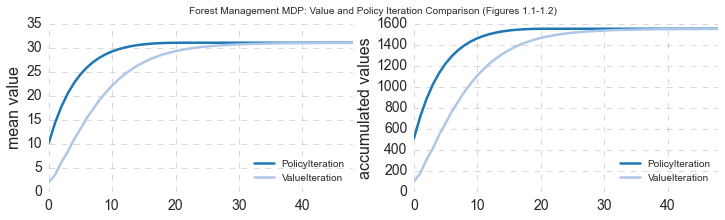

In [156]:
forest_mdp.plot_values(df)

#### Factors affecting the convergence rate


- __Age of the forest__ (number of MDP states )

    Agent is rewarded with higher values if old forest is preserved and it is evident from the optimal policy choice (see Figure 1.4). Agent is accumulating more rewards by selecting `wait` action more prominently for forest with age 100 as compared to young forest of 5 years.
    According to the current model, accumulation is more rapid for the age below 10, where action is chosen to `cut`, however as the forest aged, accumulation of rewards slowed down in favor of preserving.


- __Discount factor__

    Discount factor is affecting how much of future reward is considered relevant. For discount factors close to 1.0, there is no limit on how much reward can be accumulated (see red curve in Figure 1.5) which is known as infinite horizon and agent will never terminate. Good trade-off is achieved for discount factor equal to 0.9, where accumulation of reward is saturated with relatively small number of iterations.


- __Probability of fire__

    Another important factor to consider is probability of fire which influences the agent's decision to wait or cut the forest. If probability of fire is very small, then it makes sense to preserve the forest, however when the chance of loosing the whole forest in the fire grows, agent is forced to select `Cut` action. In this case, forest can be at least used as a resource (See Figure 1.6). In the real world probability of fire will be affected by geographical location and weather conditions. In the current model since we do not have additional factors, it makes sense to set probability of fire to 0.5.

   Note: it is sufficient to analyze the convergence factors for one of the methods (here ValueIteration is chosen since it took longer to converge and thus the effect is more prominent). Additional advantage of choose ValueIteration over PolicyIteration is algorithm runtime, where former is faster (see Figure 1.3)

In [100]:
df_age = forest_mdp.test_forest_age()
df_discount = forest_mdp.test_discount_factor()
df_fire_prob = forest_mdp.test_fire_probability()

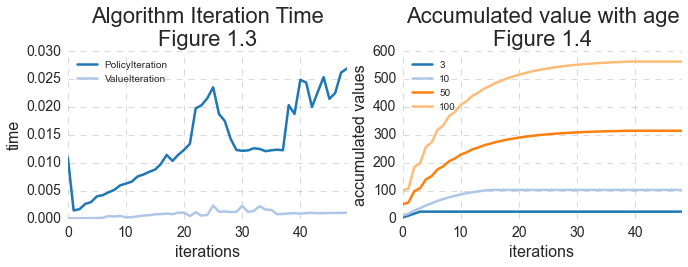

In [200]:
forest_mdp.plot_time_and_states(df, df_age)

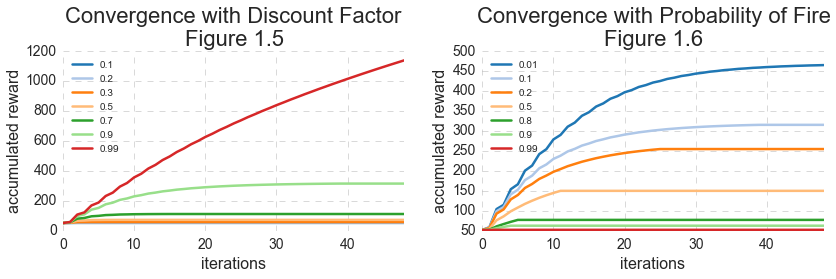

In [102]:
forest_mdp.plot_discount_factor_and_fire_probability(df_discount, df_fire_prob)

## Click Through Rate (CTR)

   In contrast to the MDP of the fire management where we defined multiple states (forest age) and only two actions (wait or cut), we will define another MDP, where we will have multiple actions and only a single state. This class of markovian processes have a special name - Multiarmed Bandit and are very useful in ad tech business.

__CTR Model__

   - __states__ - there is only one assumed state in this process.

   - __actions__ - each unique ad is represented by an action (an arm in Multiarmed Bandit jargon);
    when user visits the site, one ad will be selected to show according to the learned policy.

    For example, we might have a collection of ads `[AutoAd, EntertainmentAd, ShoppingAd, FoodAd,..]` and the learning agent decides which one to show to achieve the best performance metric overall (in the case CTR).

   - __rewards__ - each time user is shown an ad, there is a probability that he will click on it.
    Every time when click is registered, we accumulate reward of 1 unit and 0 otherwise.

    For the purpose of evaluating various algorithms, we will simulate user's behavior using __Monte Carlo__ framework - applying random number generator to simulate what might happen in real-time scenarios.

__Click Simulator__

- let's assume we have 20 ads to select from
- let's model the probability of ad resulting in user click by __Poisson__ distribution (Fig 2.1);

    In other words, there will be very few ads resulting in either high or low _clickability_ while the majority of ads will will fall under 50/50 chance.


- let's define rewards by simulating user's behavior with __Bernoulli__ process:
    * reward=1 - user clicks on the ad
    * reward=0 - user ignores the ad
    
  In the example below (Fig 2.2), where each ad was shown once, users `clicked` on 60% of ads.
  
__Optimization goal__:

   The agent is learning the sequence of ads to show that maximize the objective goal: in this case - click through rate. So, we redefine rewards, by counting how many users clicked on ad out of total users to which ad was shown.

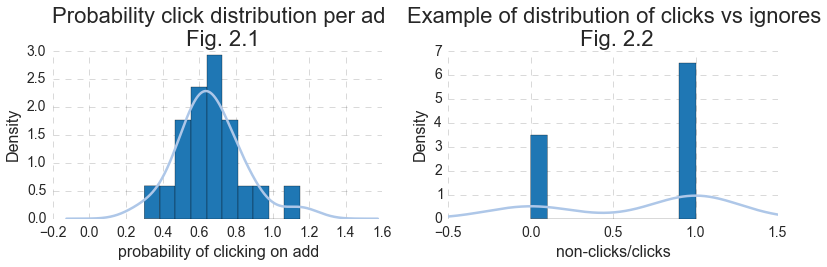

In [337]:
click_model = ctr_mdp.simulate_user_click(mu=14, n_ads=20.0)

Modeling the process as defined above (where rewards and transition probabilities are known), demonstrates the simplicity of the solution by Value and Policy Iteration. Since we only have one state, the only thing that policy needs to learn is which ad to show next - the one which has the highest CTR is chosen. Again, both algorithms give the same answer.

Convergence of the Policy Iteration is instanteneous (as shown in average and accumulate values in Fig. 2.3-2.4). This also gives great clocktime advantage (see Fig 2.5) while ValueIteration time is growing linearly with number of iterations.

In [45]:
P, R = ctr_mdp.create_ctr_mdp(n_ads=20, mu=14.0)

In [46]:
ctr_df = ctr_mdp.solve_ctr_mdp(P, R)

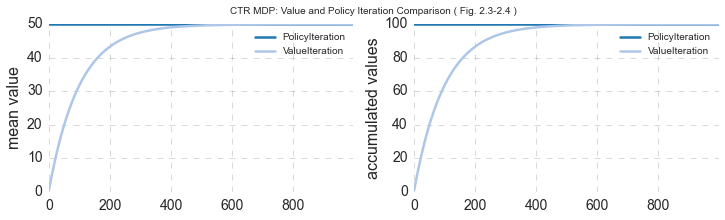

In [48]:
ctr_mdp.plot_values(ctr_df)

Convergence of the Value Iteration algorithm due to discount factor variability demonstrates similar behavior as in Fire Management MDP: if we are considering only immidiate rewards, accumulation will stop after only few iterations.

In [340]:
df_ctr_discount = ctr_mdp.test_discount_factor()

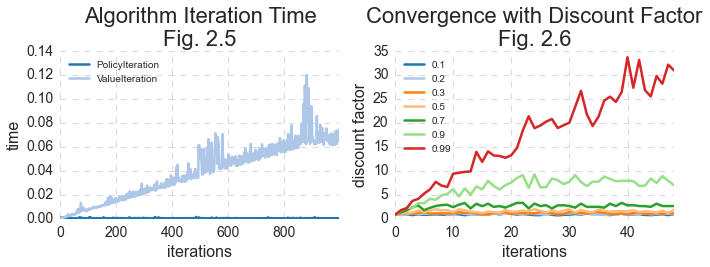

In [341]:
ctr_mdp.plot_time_and_discount(ctr_df, df_ctr_discount)

# Q Learning

Learning the optimal policy without having the model of rewards and transitions is more difficult that I have originally assumed. The fundamental question that reinforcement learning is addressing is the ability of an agent to sense an environment and to choose optimal actions in order to achieve specified goal. The most obvious way of selecting actions is the greedy approach where agent always chooses action that is shown from past experiences to produce the highest immediate reward. 

This is an example of _exploitation_ process:
- __CTR MDP__ - only display ads which have best CTR and discard those with inferior performance
- __Forest Management MDP__ - never wait for the forest to age and keep cutting to profit on wood sales

Another approach for selection actions is known as _exploration_ process, where agent is randomly selecting an action:
- __CTR MDP__ - given a list of possible ads, randomly select one and show it to user (it is bound to losing in profit since users may never click on some ads)
- __Forest Management MDP__ - randomly cut the trees (which is not an option for threatened species)

It will be good to make a trade-off between exploration and exploitation and learn the evaluation function that maximizes the cumulative reward. QLearning implementation of the `pymdptoolbox` library is using greedy with increasing probability algorithm to select actions:

            probability = 1-(1/log(n+2))

## Forest Management Revisited with QLearning

In [170]:
forest_ql = forest_mdp.test_qlearning_algorithm()

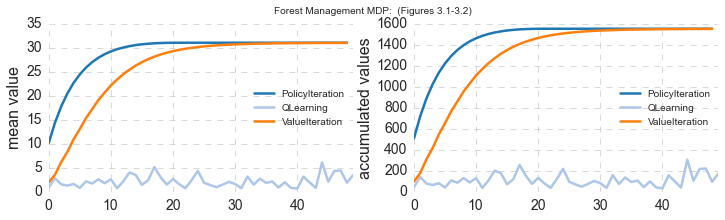

In [171]:
forest_df = pd.concat([df, forest_ql])
forest_mdp.plot_values(forest_df, title='Forest Management MDP:  (Figures 3.1-3.2)')

__Performance Comparison and Convergence__

It is a known fact that QLearning may converge under certain conditions to the true value of Q. However, in the comparison graphs below, it is clear, that QLearning does not find the optimal policy and the accumulated reward remains far less than those accumulated by Value and Policy Iteration (see Fig 3.1-3.2)

Why is Qlearning non converging?

- One of the requirements for successful convergence is _deterministic MDP_. In case of the Forest Management this condition is not satisfied as we have a _non-zero probability_ that fire will occur which affects the decisions regarding what actions to take (see experiments below which demonstrate the non-deterministic effect on learning)

- Second assumption for convergence is that agent is visiting every possible state-action pair infinitely often and that is not very practical especially if number of states if fairly large.

In [163]:
forest_ql_prob = forest_mdp.test_qlearning_deterministic()

In [164]:
forest_ql_discount = forest_mdp.test_qlearning_discounted_reward()

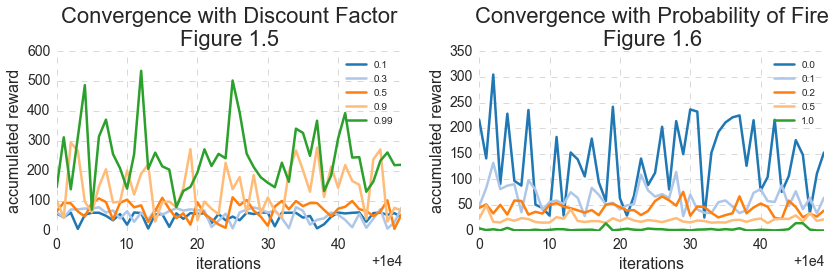

In [165]:
forest_mdp.plot_discount_factor_and_fire_probability(forest_ql_discount, forest_ql_prob)

Running experiment for 10000 iterations is definetly not sufficient to start observing the connvergence, however it is usesful to observe how learning is affected by:

- manipulating discounted factor - with discount close to 1, learned Q function is reaching cummulative rewards of 500 points
- making the world more deterministic - by assigning probability of fire to zero, learning agent is able to accumulate the most reward.

## CTR Revisited with QLearning

This problem is easier to visually compare since we assumed a single state with multiple choice actions (each representing selecting and showing the best ad).

__Agent Preference Graph__

After running the experiment for some number of iterations, a pattern begins to emerge. By collecting agent's choice of ad, it can be concluded that agent is getting stuck at local optima (more frequently choosing less optimal action - ad with smaller CTR value)

In [115]:
ctr_ql = ctr_mdp.test_qlearning_algorithm(P, R)

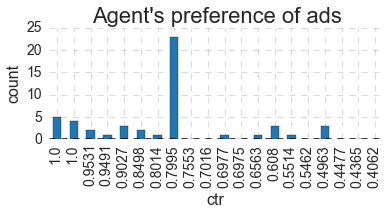

In [209]:
ctr_choice_df = ctr_mdp.evaluate_best_policy_choice(ctr_ql, R)

Using this graphs, we can make observations on the agent's choices:

- does it find the optimal policy for some episodes? Yes, some episodes do result in agent choosing the ad with best CTR=1.0
- does agent get stuck? Yes, there are quite a few cases where agent is settled on the CTR=0.79 (23 times total)
- does agent finds worse polices? Yes, on a few occasions, agent is selecting ads which have lower CTRS < 0.5.

By adjusting agent's exploiting vs exploring preferences we can make a better understood trade-off decisions to optimize overall campaign CTR.

### Clock Time and Q matrix variations

As a final experiment, it is useful to evaluate the performance of QLearning with two more metrics:

- speed of QLearning vs. Utility and Policy Iteration
- learned Q matrix variability - how much Q varies between iterations

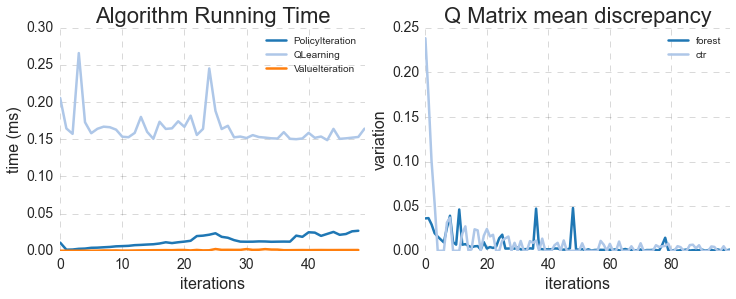

In [194]:
ctr_mdp.solve_mdp.plot_qlearn_performance(forest_df, ctr_ql)

- Learning Q Matrix is computationally more expensive since rewards values are not modeled and in order to learn them, agent must visit multiple states multiple times
- Overtime Q Matrix _variability_ converges to 0 for both presented MDPs which means that eventually the matrix produces the same learned rewards, in other words it is a good consistency.


# Conclusion

In all of the previous assignments, the success of the learning algorithm depended largely on the data and the assumptions of it's distribution. Additional domain knowledge in the form of parameter tuning aided boosting of the accuracy where possible. In contrast, this assignment did not require data, nor substantial model parameter estimation. What I saw as the most crucial step in successful agent learning, is __designing__ of the model represented by the Markovian Process. 

In case of the Forest Management, choosing the appropriate reward system and modeling the stochasticity of the world, is far more important than choosing the policy-learning algorithm. In case of the CTR optimization, finding the best way to simulate user behavior and the mechanism for selecting the proper ad, would guarantee faster agent convergence.

That being said, the choice of the algorithm for Reinforcement Learning should not be underestimated: in the environment where agent starts with no knowledge, most algorithms initially will behave the same - randomly exploring the world. However, over time, different algorithms will learn different policies where some would be more aggressive (one can imagine this not being the best idea in the world where agent is learning to drive a car in the mountain terrain). Domain knowledge can be applied here for optimal agent's behavior.

# References

- Possingham H & Tuck G, 1997, ‘Application of stochastic dynamic programming to optimal fire management of a spatially structured threatened species’, *MODSIM 1997*, vol. 2, pp. 813–817. `Available online http://www.mssanz.org.au/MODSIM97/Vol%202/Possingham.pdf`

- John Myles White, 2012, `Bandit Algorithms for Website Optimization: Developing, Deploying, and Debugging`

- Markov Decision Process (MDP) Toolbox for Python `http://pymdptoolbox.readthedocs.org/en/stable`